In [82]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
os.chdir("/scratch/ewalt/pdm/rs-uncertainty")
from src.metrics import StratifiedRCU
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
path = "/scratch/ewalt/pdm/rs-uncertainty/results/2023-04-25_17-48-18_cloud_threshold_0-50"

In [53]:
rcu = StratifiedRCU.from_json(path+"/rcu.json")

In [79]:
rcu.histogram.shape

(1, 5, 39, 1500)

In [134]:
lorcu = rcu.upsample(k=1)
hdf = pd.DataFrame(columns=["variable", "count", "variance"])
for i in range(lorcu.histogram.shape[1]):
    H = np.nansum(lorcu.histogram[0,i], axis=0)
    var = np.full(H.shape, str(i))
    bins = lorcu.histogram.bins[i]
    hdf = pd.concat([hdf, pd.DataFrame({"variable": var, "count": H, "variance": bins})])
    hdf = hdf[hdf.variance<50]

/scratch/ewalt/pdm/rs-uncertainty/src/metrics.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.nansum(values*counts, axis=axis, keepdims=keepdims)/np.nansum(counts, axis=axis, keepdims=keepdims)


In [135]:
hhdf = hdf.groupby(["variance", "variable"]).sum().reset_index()

In [136]:
hhdf

,variance,variable,count
0,8.641304e-07,4,86561.0
1,1.063788e-04,2,328.0
2,1.313164e-04,4,115519.0
3,1.380097e-04,3,99.0
4,1.652711e-04,3,1772.0
...,...,...,...
4822,4.934619e+01,0,1279.0
4823,4.944142e+01,1,27.0
4824,4.965159e+01,1,37.0
4825,4.986175e+01,1,32.0


<AxesSubplot:xlabel='variance', ylabel='count'>

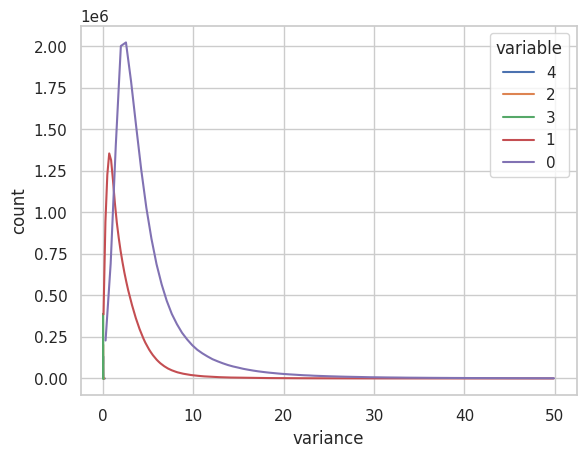

In [137]:
sns.lineplot(data=hhdf, x="variance", hue="variable", y="count")

<AxesSubplot:xlabel='variance', ylabel='Count'>

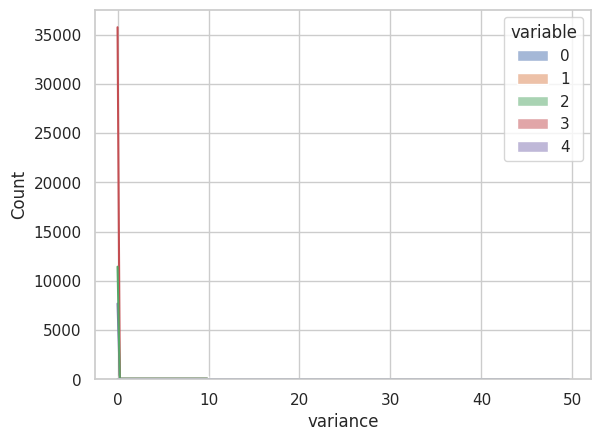

In [130]:
sns.histplot(data=hdf, x="variance", hue="variable", bins=5, kde=True)

In [100]:
hdf

,variable,count,variance
0,0,228439.0,0.280059
1,0,691599.0,0.844037
2,0,1400036.0,1.408016
3,0,2001002.0,1.971994
4,0,2022456.0,2.535973
...,...,...,...
1495,4,0.0,0.195027
1496,4,0.0,0.195157
1497,4,0.0,0.195288
1498,4,0.0,0.195418


In [91]:
sns.histplot(data=hdf, x="count", hue="variable")

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2ba843dd40> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f2ba843d7a0> (for post_execute):


KeyboardInterrupt: 

In [54]:
rcus = [rcu.copy(), rcu.copy()]
df = pd.concat([r.results for r in rcus])
df["cloud_threshold"] = list(chain(
    [0.5 for _ in range(len(rcus[0].results))],
    [1.0 for _ in range(len(rcus[1].results))]
))

In [56]:
df.cloud_threshold.unique()

array([0.5, 1. ])

In [57]:
df

,group,metric,kind,variable,x,cloud_threshold
0,439,mse,agg,P95,10.347160,0.5
1,439,mse,agg,MeanH,5.530955,0.5
2,439,mse,agg,Dens,0.016111,0.5
3,439,mse,agg,Gini,0.002769,0.5
4,439,mse,agg,Cover,0.021586,0.5
...,...,...,...,...,...,...
4725,global,srp,ause,P95,5.396044,1.0
4726,global,srp,ause,MeanH,2.567514,1.0
4727,global,srp,ause,Dens,0.007089,1.0
4728,global,srp,ause,Gini,0.001405,1.0


<AxesSubplot:xlabel='cloud_threshold', ylabel='x'>

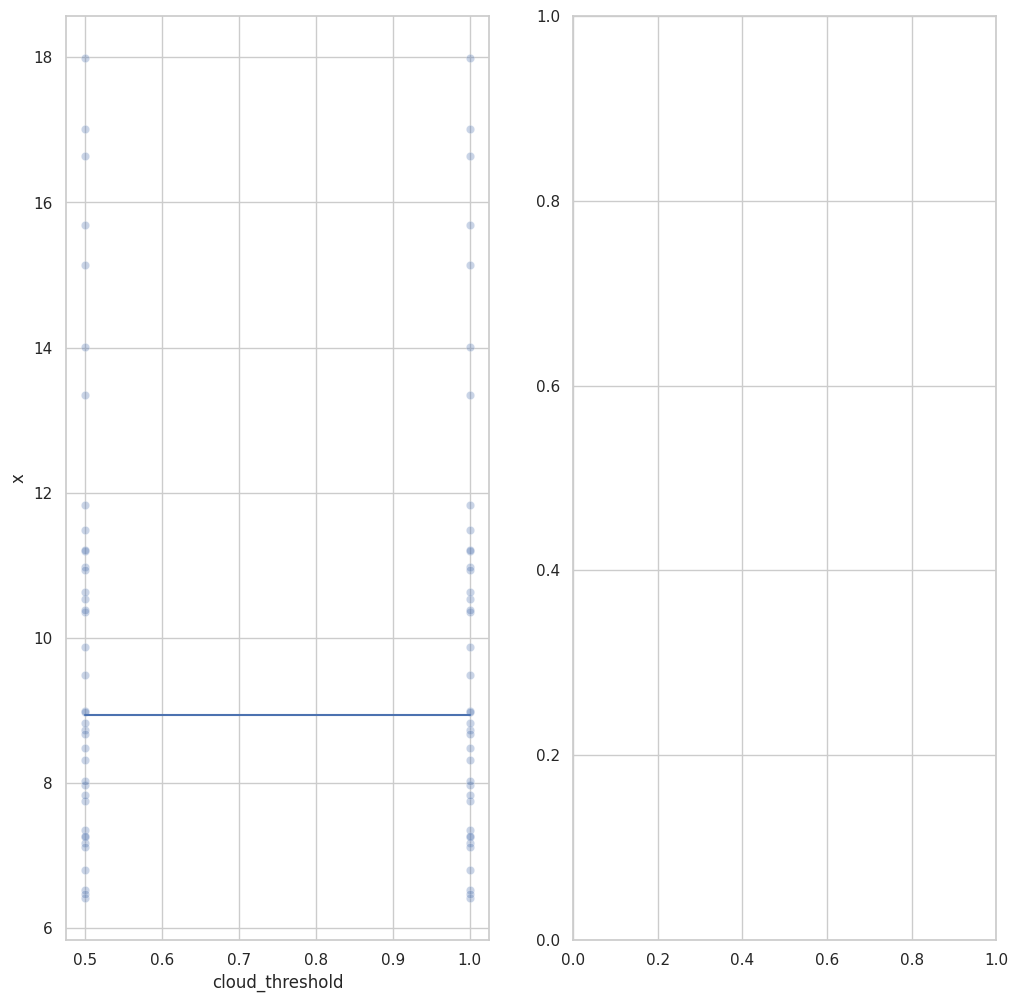

In [76]:
# VM plot
metric = "mse"
variable = "P95"
kind = "agg"
fig, axs = plt.subplots(1, 2, figsize=(12,12))
# plot global for each variable
vmdf = df.query(f"kind == '{kind}'")
vmdf = vmdf.query(f"metric == '{metric}' & variable == '{variable}'")
gvmdf = vmdf.query("group=='global'")
pvmdf = vmdf[~vmdf.group.isin(["global", "west", "north", "east"])]
sns.scatterplot(data=pvmdf, x="cloud_threshold", y="x", alpha=0.3, ax=axs[0])
sns.lineplot(data=gvmdf, x="cloud_threshold", y="x", ax=axs[0])

In [77]:
type(axs[0])

matplotlib.axes._subplots.AxesSubplot

In [78]:
gvmdf

,group,metric,kind,variable,x,cloud_threshold
4620,global,mse,agg,P95,8.937964,0.5
4620,global,mse,agg,P95,8.937964,1.0


In [63]:
pvmdf

,group,metric,kind,variable,x,cloud_threshold
0,439,mse,agg,P95,10.347160,0.5
110,471,mse,agg,P95,7.971057,0.5
220,781,mse,agg,P95,8.994483,0.5
330,792,mse,agg,P95,15.143331,0.5
440,498,mse,agg,P95,7.164374,0.5
...,...,...,...,...,...,...
3740,560,mse,agg,P95,11.484831,1.0
3850,998,mse,agg,P95,7.744142,1.0
3960,9,mse,agg,P95,7.262566,1.0
4070,988,mse,agg,P95,7.832709,1.0


In [23]:
global_df

,group,metric,kind,variable,x,cloud_threshold
4620,global,mse,agg,P95,8.937964,1.0
4621,global,mse,agg,MeanH,4.188672,1.0
4622,global,mse,agg,Dens,0.014497,1.0
4623,global,mse,agg,Gini,0.002652,1.0
4624,global,mse,agg,Cover,0.023495,1.0
4620,global,mse,agg,P95,8.937964,1.0
4621,global,mse,agg,MeanH,4.188672,1.0
4622,global,mse,agg,Dens,0.014497,1.0
4623,global,mse,agg,Gini,0.002652,1.0
4624,global,mse,agg,Cover,0.023495,1.0


<AxesSubplot:xlabel='cloud_threshold', ylabel='x'>

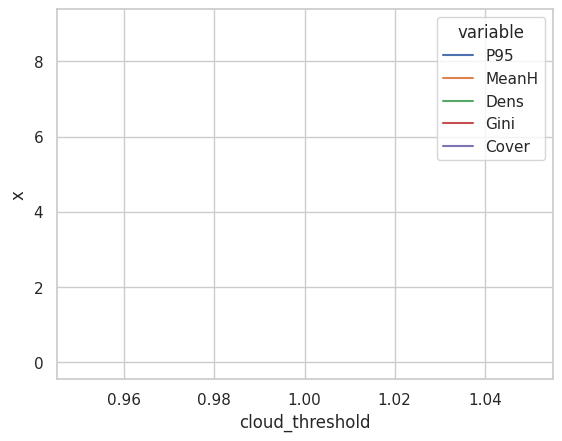

In [29]:
sns.lineplot(data=global_df, x="cloud_threshold", 
            hue="variable", y="x")